In [1]:
from glob import glob
import cv2
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
class cfg:
    dir_train = "/kaggle/input/blood-vessel-segmentation/train"
    dir_external = "/kaggle/input/blood-vessel-segmentation_external/50um_LADAF-2020-31_kidney_pag-0.01_0.02_jp2_"
    dir_raw = "/kaggle/working/dataset/stack_raw"
    dir_viz = "/kaggle/working/dataset/stack_viz"
    dir_clipped = "/kaggle/working/dataset/stack_train01"

# Stack img

In [19]:
def stack_tifs(dir_dataset, save_path):
    print(dir_dataset)
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    img_paths = glob(f"{dir_dataset}/*.???")

    stack = []
    for img_path in sorted(img_paths):
        img = cv2.imread(img_path, -1)
        stack.append(img)

    stack = np.stack(stack)
    np.save(save_path, stack)

In [35]:
for dir_dataset in glob(f"{cfg.dir_train}/*/*"):
    data_name = dir_dataset.split("/")[-2]
    data_type = dir_dataset.split("/")[-1]

    if "voi" in data_name:
        continue
    if "kidney_2" in data_name:
        data_name = "kidney_2_sparse"

    save_path = f"{cfg.dir_raw}/{data_name}_{data_type}.npy"
    stack_tifs(dir_dataset, save_path)

/kaggle/input/blood-vessel-segmentation/train/kidney_1_dense/images
/kaggle/input/blood-vessel-segmentation/train/kidney_1_dense/labels
/kaggle/input/blood-vessel-segmentation/train/kidney_2/images
/kaggle/input/blood-vessel-segmentation/train/kidney_2/labels
/kaggle/input/blood-vessel-segmentation/train/kidney_3_dense/labels
/kaggle/input/blood-vessel-segmentation/train/kidney_3_sparse/images
/kaggle/input/blood-vessel-segmentation/train/kidney_3_sparse/labels


In [20]:
# dir_external
data_name = "kidney_9_dense"
data_type = "pseudo"

save_path = f"{cfg.dir_raw}/{data_name}_{data_type}.npy"
stack_tifs(cfg.dir_external, save_path)

/kaggle/input/blood-vessel-segmentation_external/50um_LADAF-2020-31_kidney_pag-0.01_0.02_jp2_


In [39]:
for npy in sorted(glob(f"{cfg.dir_raw}/*.npy")):
    data = np.load(npy)
    print(npy.split("/")[-1], data.shape)

stack_raw\kidney_1_dense_images.npy (2279, 1303, 912)
stack_raw\kidney_1_dense_labels.npy (2279, 1303, 912)
stack_raw\kidney_2_sparse_images.npy (2217, 1041, 1511)
stack_raw\kidney_2_sparse_labels.npy (2217, 1041, 1511)
stack_raw\kidney_3_dense_labels.npy (501, 1706, 1510)
stack_raw\kidney_3_sparse_images.npy (1035, 1706, 1510)
stack_raw\kidney_3_sparse_labels.npy (1035, 1706, 1510)
stack_raw\kidney_9_dense_images.npy (2141, 1108, 1644)


# For visualization with napari

In [74]:
# napariでの可視化のために軽量化したdtypeでnpyを保存
def save_viz_npy(dir_stack, dir_viz):
    os.makedirs(dir_viz, exist_ok=True)
    # for npy_path in glob(f"{dir_stack}/*.npy"):
    for npy_path in Path(dir_stack).glob("*.npy"):
        npy_path = npy_path.as_posix()

        print(npy_path)
        data_name = npy_path.split("/")[-1].split(".")[0]
        data_type = data_name.split("_")[-1]
        save_path = f"{dir_viz}/{data_name}.npy"

        if os.path.exists(save_path):
            continue

        if data_type == "labels":
            npy = np.load(npy_path).astype(bool)
        elif data_type in ["images", "pseudo"]:
            npy = (np.load(npy_path) / 255).astype("uint8")

        np.save(save_path, npy)


save_viz_npy(cfg.dir_raw, cfg.dir_viz)

/kaggle/working/dataset/stack_raw/kidney_1_dense_images.npy
/kaggle/working/dataset/stack_raw/kidney_1_dense_labels.npy
/kaggle/working/dataset/stack_raw/kidney_2_sparse_images.npy
/kaggle/working/dataset/stack_raw/kidney_2_sparse_labels.npy
/kaggle/working/dataset/stack_raw/kidney_3_dense_labels.npy
/kaggle/working/dataset/stack_raw/kidney_3_sparse_images.npy
/kaggle/working/dataset/stack_raw/kidney_3_sparse_labels.npy
/kaggle/working/dataset/stack_raw/kidney_9_dense_images.npy


In [5]:
# kidney_3_dense_labelsをkidney_3_sparse_imagesのshapeと合わせる
dense_label_npy = np.load(f"{cfg.dir_viz}/kidney_3_dense_labels.npy")
kidney3_shape = np.load(f"{cfg.dir_viz}/kidney_3_sparse_images.npy").shape
dense_label_padded = np.zeros(kidney3_shape).astype("bool")
dense_label_padded[496:997, :, :] = dense_label_npy
np.save(f"{cfg.dir_viz}/kidney_3_dense_labels.npy", dense_label_padded)

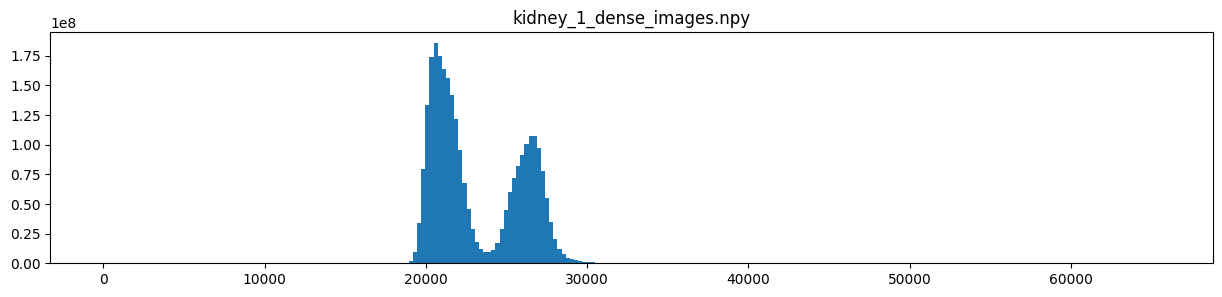

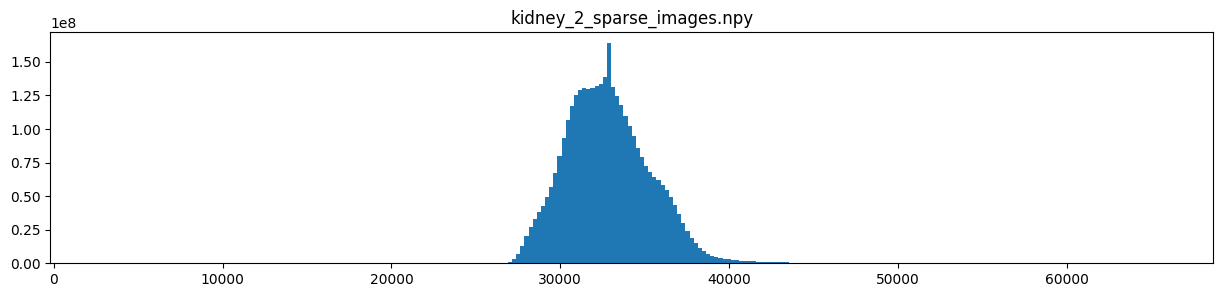

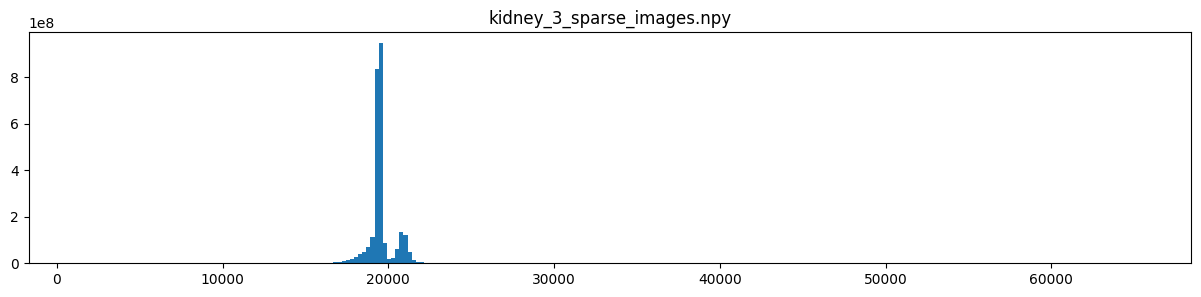

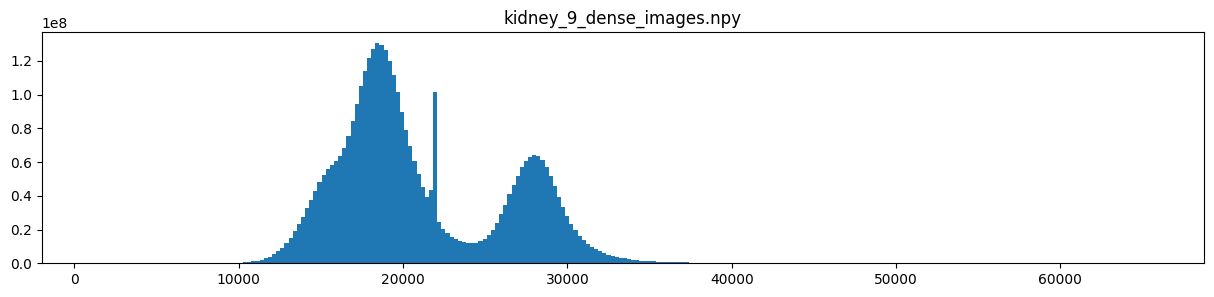

In [80]:
for npy_path in Path(cfg.dir_raw).glob("*.npy"):
    npy_path = npy_path.as_posix()
    if "labels" in npy_path:
        continue
    npy = np.load(npy_path)
    plt.figure(figsize=(15, 3))
    plt.hist(npy.flatten(), bins=256)
    plt.title(npy_path.split("/")[-1])

# For making dataset

In [3]:
def clip_based_on_percentile(npy, percentile=0.05):
    stack_len = npy.shape[0]

    upper = round(stack_len * 0.3)
    lower = round(stack_len * 0.7)

    p_low = int(np.percentile(npy[upper:lower], percentile))  # 上下端に近い部分はpercentile計算対象から除外
    p_high = int(np.percentile(npy[upper:lower], 100 - percentile))

    npy = np.clip(npy, p_low, p_high).astype("float32")
    scale = float(p_high - p_low)
    npy = (npy - p_low) / scale
    return npy


# 訓練のためにpercentileに基づいて値をクリップしfloat32で保存
def save_clipped_npy(dir_raw, dir_clipped, percentile=0.05):
    os.makedirs(dir_clipped, exist_ok=True)
    for npy_path in Path(dir_raw).glob("*.npy"):
        npy_path = npy_path.as_posix()
        if npy_path != "/kaggle/working/dataset/stack_raw/kidney_9_dense_images.npy":
            continue
        print(npy_path)
        data_name = npy_path.split("/")[-1].split(".")[0]
        data_type = data_name.split("_")[-1]
        save_path = f"{dir_clipped}/{data_name}.npy"

        if os.path.exists(save_path):
            continue

        if "voi" in npy_path:
            continue

        if "labels" == data_type:
            npy = np.load(npy_path).astype(bool)

        elif data_type in ["images", "pseudo"]:
            npy = np.load(npy_path)
            npy = clip_based_on_percentile(npy, percentile)

        np.save(save_path, npy)


percentile = 0.05  # 0.05～99.95percentile
save_clipped_npy(cfg.dir_raw, cfg.dir_clipped, percentile)

/kaggle/working/dataset/stack_raw/kidney_9_dense_images.npy


In [ ]:
sparse_images_npy = np.load(f"{cfg.dir_clipped}/kidney_3_sparse_images.npy")
sparse_images_npy = sparse_images_npy[496:997, :, :]
np.save(f"{cfg.dir_clipped}/kidney_3_dense_images.npy", sparse_images_npy)

In [4]:
sparse_images_npy = np.load(f"{cfg.dir_clipped}/kidney_3_sparse_images.npy")
sparse_labels_npy = np.load(f"{cfg.dir_clipped}/kidney_3_sparse_labels.npy")
sparse_images_npy = sparse_images_npy[:496, :, :]
sparse_labels_npy = sparse_labels_npy[:496, :, :]
np.save(f"{cfg.dir_clipped}/kidney_3_sparse_images.npy", sparse_images_npy)
np.save(f"{cfg.dir_clipped}/kidney_3_sparse_labels.npy", sparse_labels_npy)

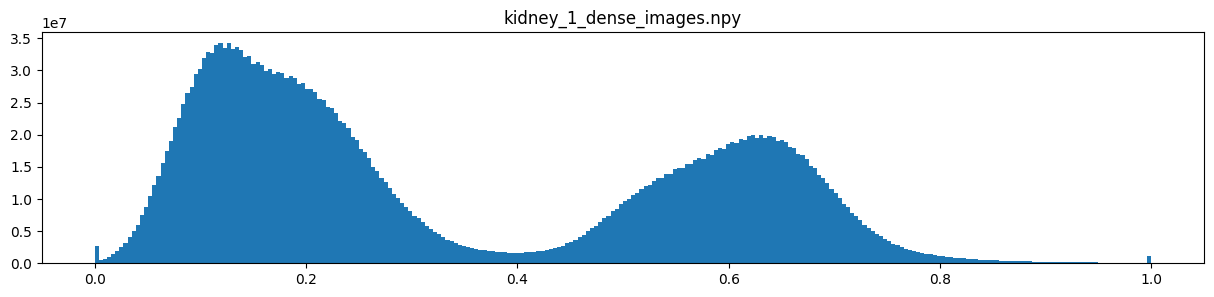

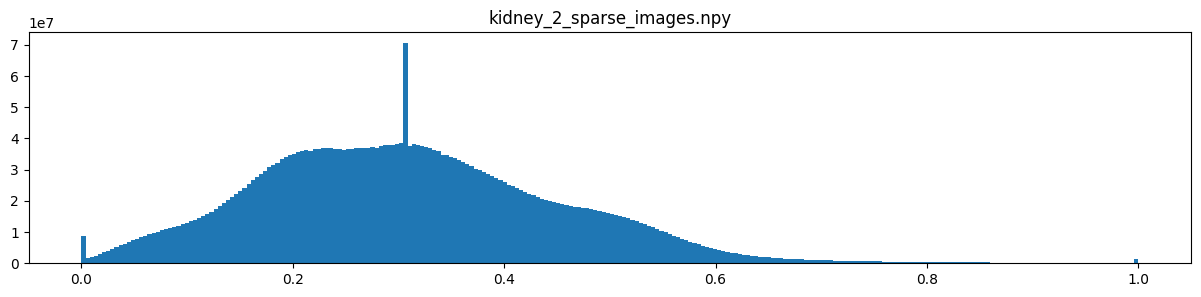

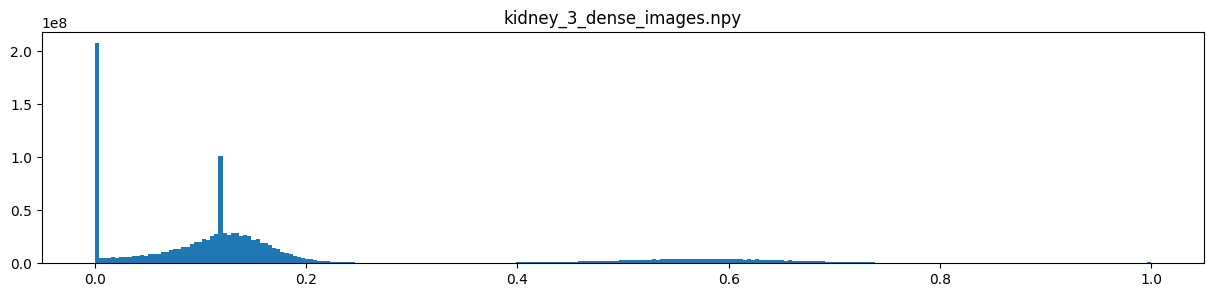

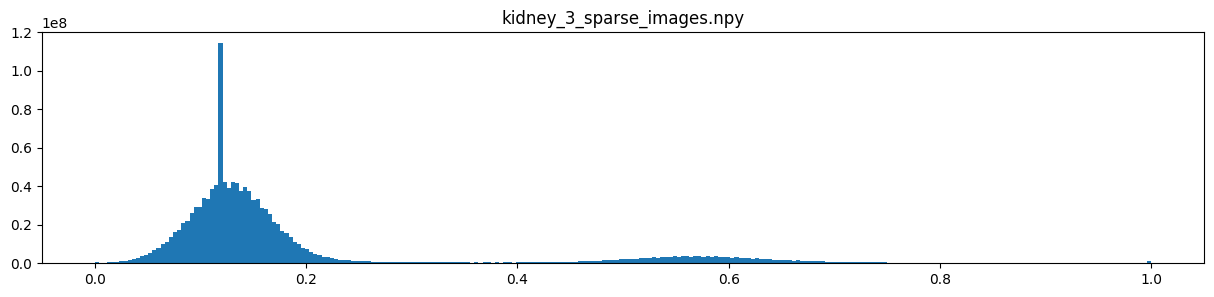

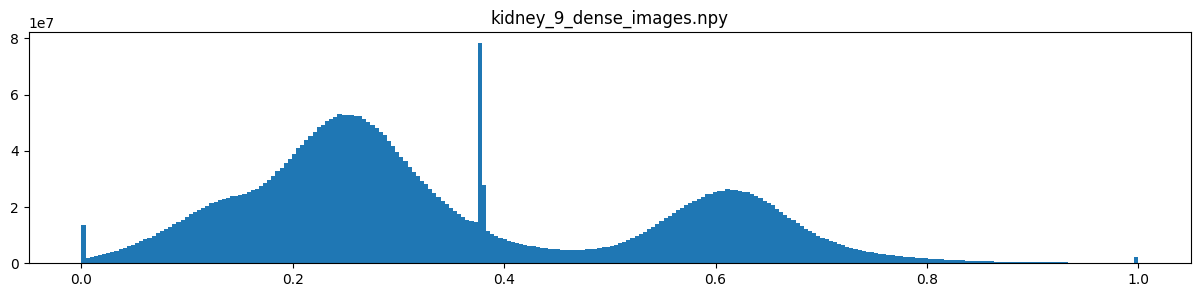

In [4]:
for npy_path in Path(cfg.dir_clipped).glob("*.npy"):
    npy_path = npy_path.as_posix()
    if "voi" in npy_path:
        continue
    if "labels" in npy_path:
        continue
    npy = np.load(npy_path)
    plt.figure(figsize=(15, 3))
    plt.hist(npy.flatten(), bins=256)
    plt.title(npy_path.split("/")[-1])